In [1]:
# Imports
import os
import torch
import numpy as np
import re

# Training/Test Set Creation - to use later
from sklearn.model_selection import StratifiedShuffleSplit

# Dataset Creation
from torch.utils.data import Dataset, DataLoader, Subset
import torchvision.transforms as transforms

# Model Training and Definition
from torch import nn
from torch import optim
from torch.optim.lr_scheduler import CosineAnnealingLR, ReduceLROnPlateau
import trainutils

In [2]:
# Specify directories
frame_folder = "./data/frames"

# Create Training and Test Sets

## Define classes and preview

In [3]:
# Define label dictionary - 20 classes
syncs = [  "0-100 ms", "101-200 ms", "201-300 ms", "301-400 ms", "401-500 ms", 
         "501-600 ms", "601-700 ms", "701-800 ms", "801-900 ms", "901-1000 ms" ]
sync_dict = {}

count = 0
for sync_val in syncs:
    sync_dict[sync_val] = count
    count += 1

# preview dictionary
sync_dict

{'0-100 ms': 0,
 '101-200 ms': 1,
 '201-300 ms': 2,
 '301-400 ms': 3,
 '401-500 ms': 4,
 '501-600 ms': 5,
 '601-700 ms': 6,
 '701-800 ms': 7,
 '801-900 ms': 8,
 '901-1000 ms': 9}

## Load training data

In [4]:
# Construct X = folder names, y = the label

vf_list = os.listdir(frame_folder)

X_paths = [] # paths of segment folders
y = [] # designated label

for vf_folder in vf_list:
    
    # Create path to video
    vf_path = os.path.join(frame_folder, vf_folder)
    print("Current Video: "+ vf_folder)
    
    # Get individual segment folder
    segfolder_list = os.listdir(vf_path)
    
    # Check every segment folder
    for seg_folder in segfolder_list:
        
        #print(seg_folder)
        x_path = os.path.join(vf_path, seg_folder)
        #print(x_path)
        X_paths.append(x_path)
        
        # Extract class label from folder name
        label = int(seg_folder.split("_")[2])
        #print(label)
        y.append(label)

Current Video: video1
Current Video: video2
Current Video: video3
Current Video: video4


In [5]:
# Preview Data distribution
from collections import Counter
Counter(y)

Counter({1: 54, 2: 49, 4: 50, 5: 51, 8: 52, 9: 52, 0: 48, 3: 50, 6: 48, 7: 50})

In [6]:
# Split into training and test sets
splitter = StratifiedShuffleSplit(n_splits = 2, test_size = 0.1, random_state = 0)
train_set, test_set = next(splitter.split(X_paths, y))

# Training Set
train_X_paths = [X_paths[i] for i in train_set]
train_ys = [y[i] for i in train_set]
print("Training Set: ({0},{1})".format(len(train_X_paths), len(train_ys)))

# Test Set
test_X_paths = [X_paths[i] for i in test_set]
test_ys = [y[i] for i in test_set]
print("Test Set: ({0},{1})".format(len(test_X_paths), len(test_ys)))
#print(test_X_paths)

Training Set: (453,453)
Test Set: (51,51)


# Create Pytorch Dataset

In [7]:
# Set seeds for reproducibility
np.random.seed(4139)
torch.manual_seed(4139)

In [8]:
# Create Dataset Class
class SyncDataset(Dataset):
    
    def __init__(self, X, y, transform=None):
        self.transform = transform
        self.X = X
        self.y = y
    
    # Returns length
    def __len__(self):
        return len(self.X)
    
    # Returns X feature array and y value
    def __getitem__(self, idx):
        
        # Load npz file
        npz_path = self.X[idx]+'/features.npz'
        #print(npz_path)
        data = np.load(npz_path)
        X_feat = data['feature_array']
        
        # Transform if needed
        
        # Convert X to tensor
        X_tensor = torch.from_numpy(X_feat).float()
        
        return X_tensor, self.y[idx] # y_tensor

In [9]:
# Define Transformer - may need it for later, unused for now
transformer = transforms.Compose([
    transforms.ToTensor() # Add min-max scaler, or an normalizer
])

In [10]:
# Define Training Dataset 
training_dataset = SyncDataset(X = train_X_paths, y = train_ys, transform = transformer)
print(len(training_dataset))

# Define Test Dataset
testing_dataset = SyncDataset(X = test_X_paths, y = test_ys, transform = transformer)
print(len(testing_dataset))

453
51


In [11]:
# Grab a row to see contents
sample_X, sample_y = training_dataset[2]
sample_X.shape, sample_y

(torch.Size([20, 168]), 6)

# Define Data Loader  

Data Loader for extracting batches from the Pytorch Dataset during model training

In [12]:
def batch_collater(batch):
    X_batch, y_batch = list(zip(*batch))
    
    # Separate batch into X and y
    X_batch = [x for x in X_batch if len(x) > 0]
    y_batch = [torch.tensor(y) for y, x in zip(y_batch, X_batch) if len(x) > 0]
    
    # Convert into tensors
    X_tensor = torch.stack(X_batch)
    y_tensor = torch.stack(y_batch).long()
    
    return X_tensor, y_tensor

In [13]:
# Specify batch size
batch_size = 30

training_loader = DataLoader(training_dataset, batch_size = batch_size, shuffle=True, collate_fn=batch_collater)
testing_loader = DataLoader(testing_dataset, batch_size = batch_size, shuffle=True, collate_fn=batch_collater)

In [14]:
for xb, yb in training_loader:
    print(xb.shape, yb.shape)
    break

for xb, yb in testing_loader:
    print(xb.shape, yb.shape)
    break

torch.Size([30, 20, 168]) torch.Size([30])
torch.Size([30, 20, 168]) torch.Size([30])


# Model Definition 

In [15]:
class SyncRNN(nn.Module):
    
    def __init__(self, params_model):
        
        super(SyncRNN, self).__init__()
        
        # Import Model Parameters
        num_classes = params_model["num_classes"]
        dr_rate = params_model["dr_rate"] # dropout rate
        rnn_hidden_size = params_model["rnn_hidden_size"]
        rnn_num_layers = params_model["rnn_num_layers"]
        num_features = 168
        
        # Define Model Structure
        self.dropout = nn.Dropout(dr_rate) # - do we need this?
        self.rnn = nn.LSTM(num_features, rnn_hidden_size, rnn_num_layers)
        self.fc1 = nn.Linear(rnn_hidden_size, num_classes)
        
    def forward(self, x):
        
        # batch count, frame count, feature size
        batch_count, frame_count, feature_size = x.shape
        frame_idx = 0
        
        # Reshape the frame
        shaped_frame = x[:, frame_idx].view(batch_count, 1, feature_size)
        
        # Feed the first frame into the rnn
        output, (hn, cn) = self.rnn(shaped_frame)
        
        # Feed the rest of the frames 
        for frame_idx in range(1, frame_count):
            shaped_frame = x[:, frame_idx].view(batch_count, 1, feature_size)
            output, (hn, cn) = self.rnn(shaped_frame, (hn, cn))
        
        #output = self.dropout(output[:,-1])
        output = self.fc1(output)
        return output
        

In [16]:
# RNN Model Parameters
model_params = {
    "num_classes": 10,
    "dr_rate": 0.1,
    "rnn_num_layers": 1,
    "rnn_hidden_size": 500,
}
model = SyncRNN(model_params)

In [17]:
# Test Model with dummy input
with torch.no_grad():
    x = torch.zeros(1, 50, 168)
    y = model(x)
    print(y.shape) # should be [1,10]

torch.Size([1, 1, 10])


In [18]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

# Print Model Params
model = model.to(device)
model

cuda:0


SyncRNN(
  (dropout): Dropout(p=0.1, inplace=False)
  (rnn): LSTM(168, 500)
  (fc1): Linear(in_features=500, out_features=10, bias=True)
)

# Model Training  

Define loss function and optimizer to train the model

In [19]:
# Define Loss Function
loss_fn = nn.CrossEntropyLoss(reduction="sum")

In [20]:
# Define Optimizer (Adam)
#optimizer = optim.Adam(model.parameters(), lr = 3e-3) #3e-5 # 3e-3
optimizer = optim.SGD(model.parameters(), lr = 1e-3, momentum=0.9) #3e-5 # 3e-3

In [21]:
# Define LR Scheduler
lr_scheduler = ReduceLROnPlateau(optimizer, mode='min', factor= 0.05, patience = 5, verbose = 1)
os.makedirs("./models", exist_ok=True)

In [22]:
# Define Training Parameters - tweak this
train_params = {
    "num_epochs": 100, 
    "optimizer": optimizer,
    "loss_fn": loss_fn,
    "training_loader": training_loader,
    "testing_loader": testing_loader,
    "lr_scheduler": lr_scheduler,
    "weights_path": "./models/weights_kpf_sgd.pt",
}

In [23]:
trained_model, loss_hist, metric_hist = trainutils.train_model(model, train_params)

Epoch 0/99, current_lr=0.001



Saved best model weights
Train Loss: 2.407415, Dev Loss: 2.593328, Accuracy: 9.80
----------
Epoch 1/99, current_lr=0.001



Train Loss: 2.550105, Dev Loss: 2.789169, Accuracy: 9.80
----------
Epoch 2/99, current_lr=0.001



Train Loss: 2.614325, Dev Loss: 2.800073, Accuracy: 11.76
----------
Epoch 3/99, current_lr=0.001



Train Loss: 2.543650, Dev Loss: 2.595903, Accuracy: 9.80
----------
Epoch 4/99, current_lr=0.001



Train Loss: 2.585044, Dev Loss: 2.790472, Accuracy: 11.76
----------
Epoch 5/99, current_lr=0.001



Train Loss: 2.689214, Dev Loss: 2.596111, Accuracy: 9.80
----------
Epoch 6/99, current_lr=0.001



Epoch     7: reducing learning rate of group 0 to 5.0000e-05.
Loading best model weights
Train Loss: 2.616554, Dev Loss: 2.800786, Accuracy: 9.80
----------
Epoch 7/99, current_lr=5e-05



Saved best model weights
Train Loss: 2.411271, Dev Loss: 2.321619, Accuracy: 5.88
----------
Epoch 8/99, current_lr=5e-05



Saved best model weights
Train Loss: 2.315825, Dev Loss: 2.312570, Accuracy: 7.84
----------
Epoch 9/99, current_lr=5e-05



Saved best model weights
Train Loss: 2.304180, Dev Loss: 2.308784, Accuracy: 9.80
----------
Epoch 10/99, current_lr=5e-05



Saved best model weights
Train Loss: 2.303925, Dev Loss: 2.304008, Accuracy: 11.76
----------
Epoch 11/99, current_lr=5e-05



Saved best model weights
Train Loss: 2.301324, Dev Loss: 2.301349, Accuracy: 11.76
----------
Epoch 12/99, current_lr=5e-05



Train Loss: 2.299529, Dev Loss: 2.305874, Accuracy: 11.76
----------
Epoch 13/99, current_lr=5e-05



Train Loss: 2.299657, Dev Loss: 2.304900, Accuracy: 7.84
----------
Epoch 14/99, current_lr=5e-05



Train Loss: 2.299804, Dev Loss: 2.303289, Accuracy: 5.88
----------
Epoch 15/99, current_lr=5e-05



Saved best model weights
Train Loss: 2.295645, Dev Loss: 2.299388, Accuracy: 9.80
----------
Epoch 16/99, current_lr=5e-05



Saved best model weights
Train Loss: 2.296004, Dev Loss: 2.297618, Accuracy: 9.80
----------
Epoch 17/99, current_lr=5e-05



Train Loss: 2.296755, Dev Loss: 2.301205, Accuracy: 13.73
----------
Epoch 18/99, current_lr=5e-05



Saved best model weights
Train Loss: 2.292774, Dev Loss: 2.295332, Accuracy: 9.80
----------
Epoch 19/99, current_lr=5e-05



Saved best model weights
Train Loss: 2.291874, Dev Loss: 2.293553, Accuracy: 15.69
----------
Epoch 20/99, current_lr=5e-05



Train Loss: 2.297009, Dev Loss: 2.293850, Accuracy: 11.76
----------
Epoch 21/99, current_lr=5e-05



Train Loss: 2.291627, Dev Loss: 2.296843, Accuracy: 13.73
----------
Epoch 22/99, current_lr=5e-05



Saved best model weights
Train Loss: 2.288400, Dev Loss: 2.291658, Accuracy: 11.76
----------
Epoch 23/99, current_lr=5e-05



Saved best model weights
Train Loss: 2.291364, Dev Loss: 2.290484, Accuracy: 5.88
----------
Epoch 24/99, current_lr=5e-05



Train Loss: 2.285693, Dev Loss: 2.291328, Accuracy: 9.80
----------
Epoch 25/99, current_lr=5e-05



Saved best model weights
Train Loss: 2.294638, Dev Loss: 2.287820, Accuracy: 13.73
----------
Epoch 26/99, current_lr=5e-05



Train Loss: 2.287711, Dev Loss: 2.292516, Accuracy: 9.80
----------
Epoch 27/99, current_lr=5e-05



Saved best model weights
Train Loss: 2.290042, Dev Loss: 2.287805, Accuracy: 7.84
----------
Epoch 28/99, current_lr=5e-05



Train Loss: 2.288108, Dev Loss: 2.293504, Accuracy: 11.76
----------
Epoch 29/99, current_lr=5e-05



Train Loss: 2.287846, Dev Loss: 2.289726, Accuracy: 13.73
----------
Epoch 30/99, current_lr=5e-05



Train Loss: 2.285260, Dev Loss: 2.290980, Accuracy: 11.76
----------
Epoch 31/99, current_lr=5e-05



Epoch    32: reducing learning rate of group 0 to 2.5000e-06.
Loading best model weights
Train Loss: 2.284648, Dev Loss: 2.291407, Accuracy: 9.80
----------
Epoch 32/99, current_lr=2.5e-06



Train Loss: 2.279435, Dev Loss: 2.288763, Accuracy: 7.84
----------
Epoch 33/99, current_lr=2.5e-06



Train Loss: 2.279776, Dev Loss: 2.288223, Accuracy: 11.76
----------
Epoch 34/99, current_lr=2.5e-06



Train Loss: 2.278890, Dev Loss: 2.289666, Accuracy: 11.76
----------
Epoch 35/99, current_lr=2.5e-06



Train Loss: 2.277544, Dev Loss: 2.290695, Accuracy: 9.80
----------
Epoch 36/99, current_lr=2.5e-06



Train Loss: 2.277918, Dev Loss: 2.287978, Accuracy: 11.76
----------
Epoch 37/99, current_lr=2.5e-06



Saved best model weights
Train Loss: 2.277508, Dev Loss: 2.287125, Accuracy: 9.80
----------
Epoch 38/99, current_lr=2.5e-06



Train Loss: 2.278599, Dev Loss: 2.287774, Accuracy: 11.76
----------
Epoch 39/99, current_lr=2.5e-06



Train Loss: 2.276771, Dev Loss: 2.287216, Accuracy: 11.76
----------
Epoch 40/99, current_lr=2.5e-06



Saved best model weights
Train Loss: 2.275672, Dev Loss: 2.287104, Accuracy: 11.76
----------
Epoch 41/99, current_lr=2.5e-06



Train Loss: 2.275491, Dev Loss: 2.290710, Accuracy: 7.84
----------
Epoch 42/99, current_lr=2.5e-06



Saved best model weights
Train Loss: 2.277626, Dev Loss: 2.286162, Accuracy: 13.73
----------
Epoch 43/99, current_lr=2.5e-06



Train Loss: 2.276690, Dev Loss: 2.288215, Accuracy: 11.76
----------
Epoch 44/99, current_lr=2.5e-06



Train Loss: 2.275960, Dev Loss: 2.292056, Accuracy: 9.80
----------
Epoch 45/99, current_lr=2.5e-06



Saved best model weights
Train Loss: 2.278251, Dev Loss: 2.285702, Accuracy: 11.76
----------
Epoch 46/99, current_lr=2.5e-06



Train Loss: 2.277315, Dev Loss: 2.288726, Accuracy: 13.73
----------
Epoch 47/99, current_lr=2.5e-06



Train Loss: 2.276502, Dev Loss: 2.288643, Accuracy: 17.65
----------
Epoch 48/99, current_lr=2.5e-06



Train Loss: 2.275460, Dev Loss: 2.289621, Accuracy: 13.73
----------
Epoch 49/99, current_lr=2.5e-06



Train Loss: 2.276399, Dev Loss: 2.286861, Accuracy: 13.73
----------
Epoch 50/99, current_lr=2.5e-06



Train Loss: 2.276477, Dev Loss: 2.288203, Accuracy: 13.73
----------
Epoch 51/99, current_lr=2.5e-06



Epoch    52: reducing learning rate of group 0 to 1.2500e-07.
Loading best model weights
Train Loss: 2.276364, Dev Loss: 2.288131, Accuracy: 13.73
----------
Epoch 52/99, current_lr=1.2500000000000002e-07



Train Loss: 2.275897, Dev Loss: 2.291510, Accuracy: 11.76
----------
Epoch 53/99, current_lr=1.2500000000000002e-07



Train Loss: 2.275377, Dev Loss: 2.288300, Accuracy: 15.69
----------
Epoch 54/99, current_lr=1.2500000000000002e-07



Train Loss: 2.274681, Dev Loss: 2.289187, Accuracy: 11.76
----------
Epoch 55/99, current_lr=1.2500000000000002e-07



Train Loss: 2.275580, Dev Loss: 2.289205, Accuracy: 11.76
----------
Epoch 56/99, current_lr=1.2500000000000002e-07



Train Loss: 2.276618, Dev Loss: 2.286203, Accuracy: 11.76
----------
Epoch 57/99, current_lr=1.2500000000000002e-07



Epoch    58: reducing learning rate of group 0 to 6.2500e-09.
Loading best model weights
Train Loss: 2.276009, Dev Loss: 2.286133, Accuracy: 15.69
----------
Epoch 58/99, current_lr=6.250000000000001e-09



Train Loss: 2.274796, Dev Loss: 2.287502, Accuracy: 9.80
----------
Epoch 59/99, current_lr=6.250000000000001e-09



Train Loss: 2.276077, Dev Loss: 2.289022, Accuracy: 9.80
----------
Epoch 60/99, current_lr=6.250000000000001e-09



Train Loss: 2.276501, Dev Loss: 2.289635, Accuracy: 9.80
----------
Epoch 61/99, current_lr=6.250000000000001e-09



Train Loss: 2.276337, Dev Loss: 2.289449, Accuracy: 9.80
----------
Epoch 62/99, current_lr=6.250000000000001e-09



Train Loss: 2.276840, Dev Loss: 2.290457, Accuracy: 9.80
----------
Epoch 63/99, current_lr=6.250000000000001e-09



Train Loss: 2.275127, Dev Loss: 2.291173, Accuracy: 9.80
----------
Epoch 64/99, current_lr=6.250000000000001e-09



Train Loss: 2.275224, Dev Loss: 2.287882, Accuracy: 9.80
----------
Epoch 65/99, current_lr=6.250000000000001e-09



Train Loss: 2.276430, Dev Loss: 2.285720, Accuracy: 11.76
----------
Epoch 66/99, current_lr=6.250000000000001e-09



Train Loss: 2.276420, Dev Loss: 2.288073, Accuracy: 11.76
----------
Epoch 67/99, current_lr=6.250000000000001e-09



Train Loss: 2.276697, Dev Loss: 2.288444, Accuracy: 9.80
----------
Epoch 68/99, current_lr=6.250000000000001e-09



Train Loss: 2.275794, Dev Loss: 2.287602, Accuracy: 11.76
----------
Epoch 69/99, current_lr=6.250000000000001e-09



Train Loss: 2.276569, Dev Loss: 2.290531, Accuracy: 9.80
----------
Epoch 70/99, current_lr=6.250000000000001e-09



Train Loss: 2.276093, Dev Loss: 2.287443, Accuracy: 11.76
----------
Epoch 71/99, current_lr=6.250000000000001e-09



Train Loss: 2.275102, Dev Loss: 2.288371, Accuracy: 9.80
----------
Epoch 72/99, current_lr=6.250000000000001e-09



Saved best model weights
Train Loss: 2.274759, Dev Loss: 2.284680, Accuracy: 13.73
----------
Epoch 73/99, current_lr=6.250000000000001e-09



Train Loss: 2.276001, Dev Loss: 2.290362, Accuracy: 9.80
----------
Epoch 74/99, current_lr=6.250000000000001e-09



Train Loss: 2.275733, Dev Loss: 2.286242, Accuracy: 9.80
----------
Epoch 75/99, current_lr=6.250000000000001e-09



Train Loss: 2.274956, Dev Loss: 2.288104, Accuracy: 11.76
----------
Epoch 76/99, current_lr=6.250000000000001e-09



Train Loss: 2.275794, Dev Loss: 2.286813, Accuracy: 9.80
----------
Epoch 77/99, current_lr=6.250000000000001e-09



Train Loss: 2.276502, Dev Loss: 2.289907, Accuracy: 9.80
----------
Epoch 78/99, current_lr=6.250000000000001e-09



Train Loss: 2.276471, Dev Loss: 2.288247, Accuracy: 11.76
----------
Epoch 79/99, current_lr=6.250000000000001e-09



Train Loss: 2.275469, Dev Loss: 2.290505, Accuracy: 9.80
----------
Epoch 80/99, current_lr=6.250000000000001e-09



Train Loss: 2.275152, Dev Loss: 2.288860, Accuracy: 13.73
----------
Epoch 81/99, current_lr=6.250000000000001e-09



Train Loss: 2.275401, Dev Loss: 2.293699, Accuracy: 11.76
----------
Epoch 82/99, current_lr=6.250000000000001e-09



Train Loss: 2.276443, Dev Loss: 2.288570, Accuracy: 11.76
----------
Epoch 83/99, current_lr=6.250000000000001e-09



Train Loss: 2.276138, Dev Loss: 2.288942, Accuracy: 9.80
----------
Epoch 84/99, current_lr=6.250000000000001e-09



Train Loss: 2.274716, Dev Loss: 2.285610, Accuracy: 13.73
----------
Epoch 85/99, current_lr=6.250000000000001e-09



Train Loss: 2.277365, Dev Loss: 2.290048, Accuracy: 11.76
----------
Epoch 86/99, current_lr=6.250000000000001e-09



Train Loss: 2.277491, Dev Loss: 2.288509, Accuracy: 11.76
----------
Epoch 87/99, current_lr=6.250000000000001e-09



Train Loss: 2.274768, Dev Loss: 2.287977, Accuracy: 9.80
----------
Epoch 88/99, current_lr=6.250000000000001e-09



Train Loss: 2.275866, Dev Loss: 2.289739, Accuracy: 11.76
----------
Epoch 89/99, current_lr=6.250000000000001e-09



Train Loss: 2.276803, Dev Loss: 2.287063, Accuracy: 9.80
----------
Epoch 90/99, current_lr=6.250000000000001e-09



Train Loss: 2.276318, Dev Loss: 2.289712, Accuracy: 11.76
----------
Epoch 91/99, current_lr=6.250000000000001e-09



Train Loss: 2.275419, Dev Loss: 2.288228, Accuracy: 9.80
----------
Epoch 92/99, current_lr=6.250000000000001e-09



Train Loss: 2.276469, Dev Loss: 2.288998, Accuracy: 11.76
----------
Epoch 93/99, current_lr=6.250000000000001e-09



Train Loss: 2.275512, Dev Loss: 2.287638, Accuracy: 11.76
----------
Epoch 94/99, current_lr=6.250000000000001e-09



Train Loss: 2.275300, Dev Loss: 2.291656, Accuracy: 9.80
----------
Epoch 95/99, current_lr=6.250000000000001e-09



Train Loss: 2.276158, Dev Loss: 2.290630, Accuracy: 11.76
----------
Epoch 96/99, current_lr=6.250000000000001e-09



Train Loss: 2.276572, Dev Loss: 2.290156, Accuracy: 9.80
----------
Epoch 97/99, current_lr=6.250000000000001e-09



Train Loss: 2.276635, Dev Loss: 2.291638, Accuracy: 11.76
----------
Epoch 98/99, current_lr=6.250000000000001e-09



Train Loss: 2.276585, Dev Loss: 2.289765, Accuracy: 11.76
----------
Epoch 99/99, current_lr=6.250000000000001e-09



Train Loss: 2.276711, Dev Loss: 2.289080, Accuracy: 9.80
----------


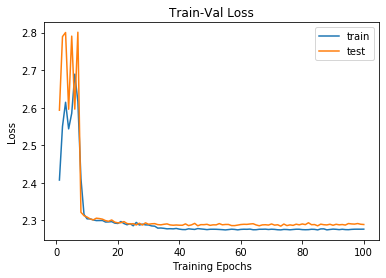

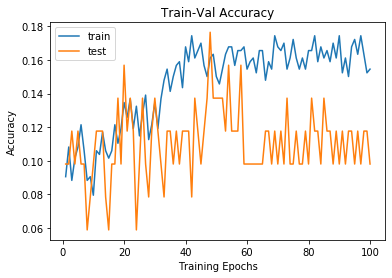

In [24]:
trainutils.plot_loss(loss_hist, metric_hist)